In [264]:
# to install required libraries
#!pip install librosa numpy scikit-learn matplotlib seaborn imbalanced-learn xgboost tensorflow pandas

In [45]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Flatten,SimpleRNN,Conv1D, MaxPooling1D
import pandas as pd
from tensorflow.keras.models import Model
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings("ignore")


In [26]:
# Dataset Path
data_path = 'D:/NCI/Sem 3/Thesis/code_DB/dataset'

In [27]:
#classes
class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Initialize lists to hold features and labels
X = []
y = []

# Parameters for feature extraction
n_mfcc = 13  # Number of MFCC features to extract
n_chroma = 12  # Number of chroma features
n_spectral_contrast = 7  # Number of spectral contrast features
max_pad_len = 174  # Ensure all audio files have the same length


In [28]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy','F1 Score','Precision','Recall'])

In [29]:
def extract_mfcc(file_path):
    """Extract MFCC features from a given audio file."""
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    # Pad or truncate the MFCCs to a fixed length
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs

In [30]:
# Loop through each class folder and extract MFCCs
for i, label in enumerate(class_labels):
    folder_path = os.path.join(data_path, label)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            mfcc = extract_mfcc(file_path)
            X.append(mfcc)
            y.append(i)  # Store the class label as an integer

In [31]:
# Convert to numpy arrays
X_mfcc = np.array(X)
y_mfcc = np.array(y)
X1 = X_mfcc
y1 = y_mfcc

In [32]:
X1.shape

(457, 13, 174)

In [33]:
# Reshape X to be suitable for the SVM
X_mfcc = X_mfcc.reshape(X_mfcc.shape[0], -1)  # Flatten the MFCC array

In [34]:
print(f'Extracted {X_mfcc.shape[0]} samples with shape {X_mfcc.shape}')

Extracted 457 samples with shape (457, 2262)


## EDA

C:\Users\YOGA\AppData\Local\Temp\ipykernel_11416\4093973876.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=[class_labels[i] for i in class_counts.index], y=class_counts.values, palette='muted')


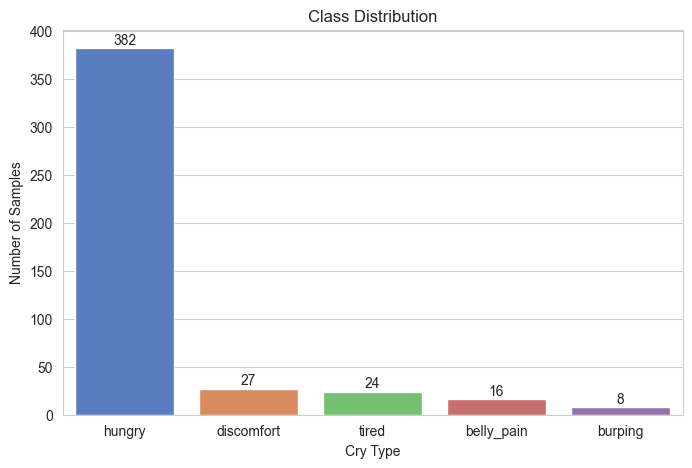

In [35]:
# 1. Class Distribution
class_counts = pd.Series(y1).value_counts()
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=[class_labels[i] for i in class_counts.index], y=class_counts.values, palette='muted')
plt.title("Class Distribution")
plt.xlabel("Cry Type")
plt.ylabel("Number of Samples")

# Adding labels to each bar
for bar in barplot.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate
        bar.get_height() + 1,  # Y-coordinate (a bit above the bar)
        f'{int(bar.get_height())}',  # Value to annotate
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

plt.show()

In [36]:
# 2. Statistical Summary of Features
X_flat1 = X1.reshape(X1.shape[0], -1)  # Flatten MFCC for statistical analysis
df_features = pd.DataFrame(X_flat1)
feature_stats = df_features.describe().T  # Get statistical properties
print("Statistical Summary of MFCC Features:")
feature_stats

Statistical Summary of MFCC Features:


,count,mean,std,min,25%,50%,75%,max
0,457.0,-519.123108,140.756165,-940.666565,-596.720154,-531.550171,-445.531891,-129.125702
1,457.0,-510.267639,144.053970,-942.565063,-594.822510,-527.779175,-419.859924,-113.522888
2,457.0,-510.809631,142.002777,-946.387634,-594.681641,-525.448059,-422.520813,-126.374825
3,457.0,-509.989166,146.362457,-946.387634,-597.620300,-527.023499,-414.964813,-128.918091
4,457.0,-506.534271,147.852310,-946.387634,-597.035522,-525.130249,-397.697998,-133.624603
...,...,...,...,...,...,...,...,...
2257,457.0,-3.407335,11.183582,-29.675323,-11.062315,-5.037594,2.245853,28.341309
2258,457.0,-3.541670,11.087759,-36.471909,-10.927980,-5.112499,1.765492,27.883514
2259,457.0,-3.685238,10.785473,-34.931213,-10.374995,-4.813103,1.820382,28.977554
2260,457.0,-3.578897,10.935289,-31.074707,-10.560262,-4.796652,1.768992,38.364296


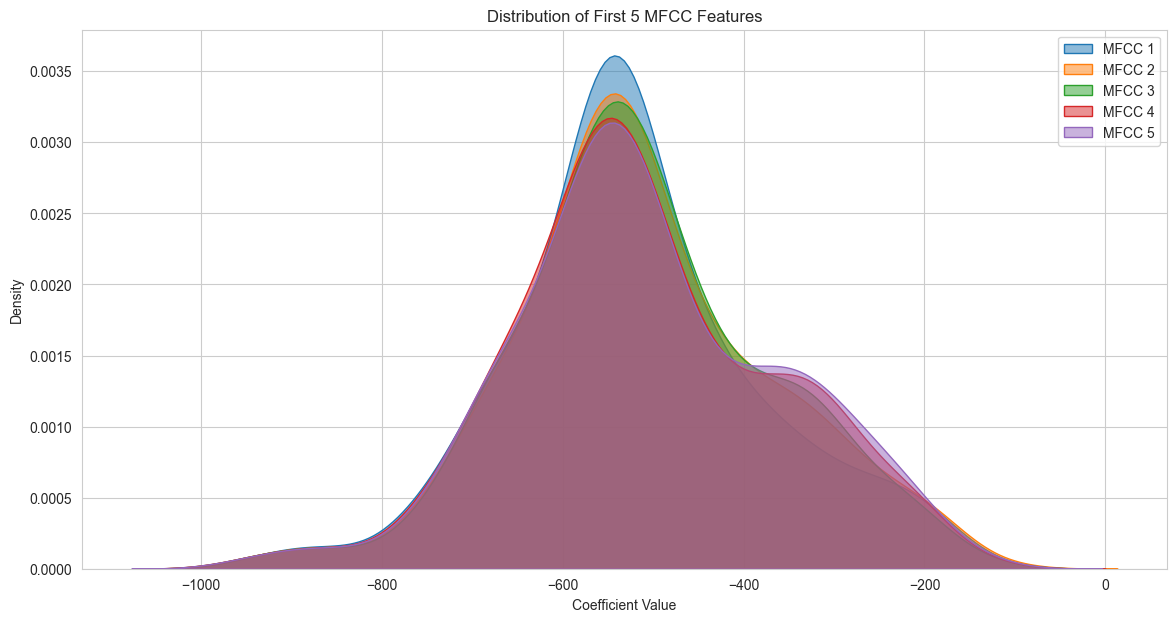

In [17]:
# 3. Visualizing Feature Distributions
plt.figure(figsize=(14, 7))
for i in range(5):  # Visualize first 5 MFCC coefficients
    sns.kdeplot(X_flat1[:, i], label=f'MFCC {i+1}', fill=True, alpha=0.5)
plt.title("Distribution of First 5 MFCC Features")
plt.xlabel("Coefficient Value")
plt.ylabel("Density")
plt.legend()
plt.show()

C:\Users\YOGA\AppData\Local\Temp\ipykernel_11416\2828202565.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y1, y=durations, palette="muted")


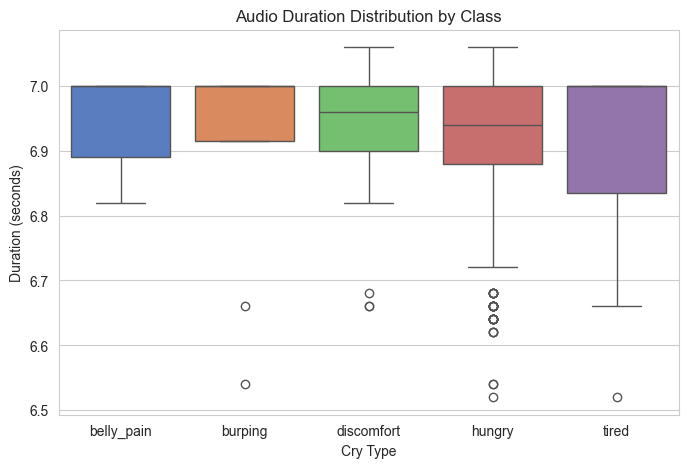

In [20]:
# 4. Audio Duration Analysis
durations = []
for i, label in enumerate(class_labels):
    folder_path = os.path.join(data_path, label)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            audio, sr = librosa.load(file_path, res_type='kaiser_fast')
            durations.append(len(audio) / sr)
plt.figure(figsize=(8, 5))
sns.boxplot(x=y1, y=durations, palette="muted")
plt.title("Audio Duration Distribution by Class")
plt.xlabel("Cry Type")
plt.ylabel("Duration (seconds)")
plt.xticks(ticks=range(len(class_labels)), labels=class_labels)
plt.show()

## Simple models with original data

In [37]:
#Split the data into training and test sets
X_mfcc_train, X_mfcc_test, y_mfcc_train, y_mfcc_test = train_test_split(X_mfcc, y_mfcc, test_size=0.2, random_state=42)

1. SVM model Simple

In [38]:
# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

In [39]:
# Define a list of scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}



In [40]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(svm_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [41]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["SVM (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df



5-Fold Cross-Validation Accuracy: 0.77
5-Fold Cross-Validation F1_weighted: 0.75
5-Fold Cross-Validation Precision_weighted: 0.73
5-Fold Cross-Validation Recall_weighted: 0.77


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123


In [42]:
# Refit the model with the training data for confusion matrix and report
svm_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = svm_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))




              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.25      0.14      0.18         7
      hungry       0.81      0.85      0.83        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.67        92
   macro avg       0.21      0.20      0.20        92
weighted avg       0.66      0.67      0.66        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

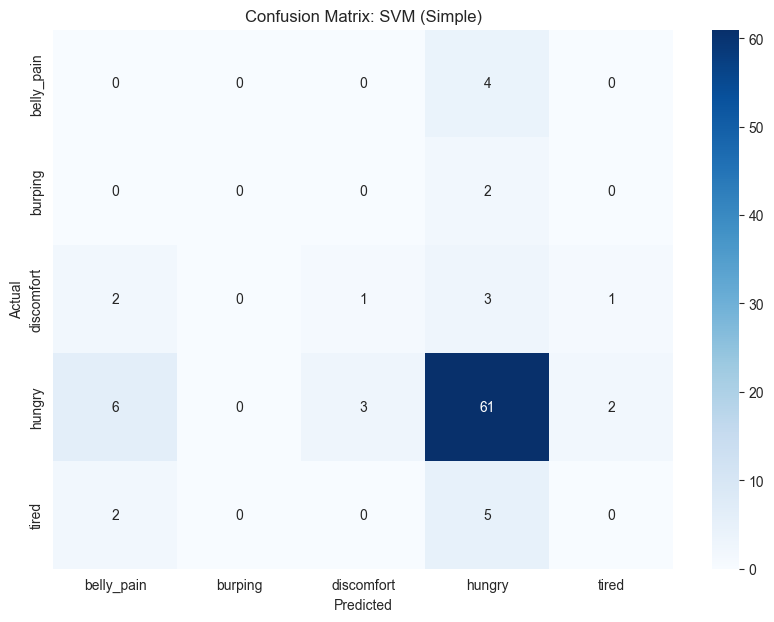

In [43]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM (Simple)')
plt.show()

2. KNN-Simple

In [52]:
# Step 1: Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors based on your analysis

# Step 2: Define scoring metrics for cross-validation
'''scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}'''

# Step 3: Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(knn_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

# Step 4: Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["KNN (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

5-Fold Cross-Validation Accuracy: 0.84
5-Fold Cross-Validation F1_weighted: 0.77
5-Fold Cross-Validation Precision_weighted: 0.72
5-Fold Cross-Validation Recall_weighted: 0.84


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      0.99      0.87        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.77        92
   macro avg       0.16      0.20      0.17        92
weighted avg       0.61      0.77      0.68        92



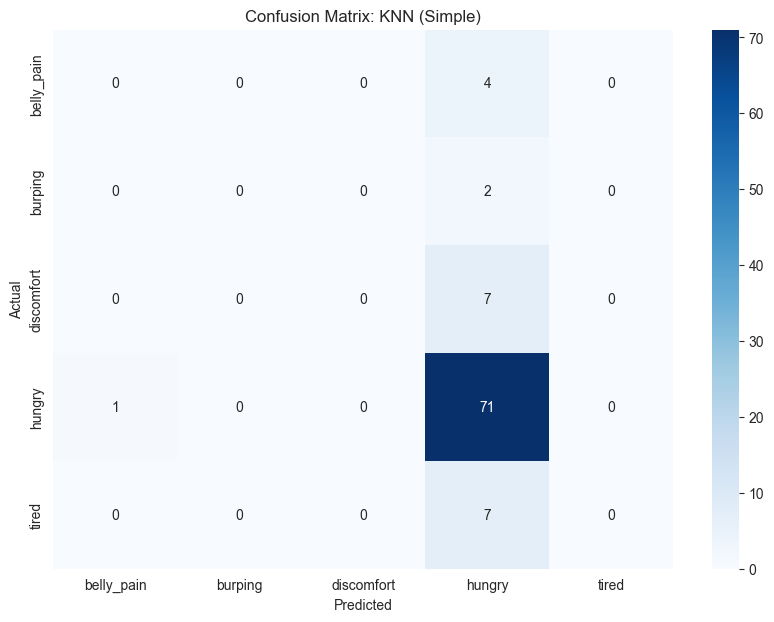

In [53]:
# Refit the model with the training data for confusion matrix and report
knn_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = knn_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: KNN (Simple)')
plt.show()

3. Random Forest (Simple)

In [55]:
# Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [56]:
# Step 3: Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(rf_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

In [57]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.85
5-Fold Cross-Validation F1_weighted: 0.78
5-Fold Cross-Validation Precision_weighted: 0.72
5-Fold Cross-Validation Recall_weighted: 0.85


In [58]:
# Step : Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["Random Forest (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      1.00      0.88        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.78        92
   macro avg       0.16      0.20      0.18        92
weighted avg       0.61      0.78      0.69        92



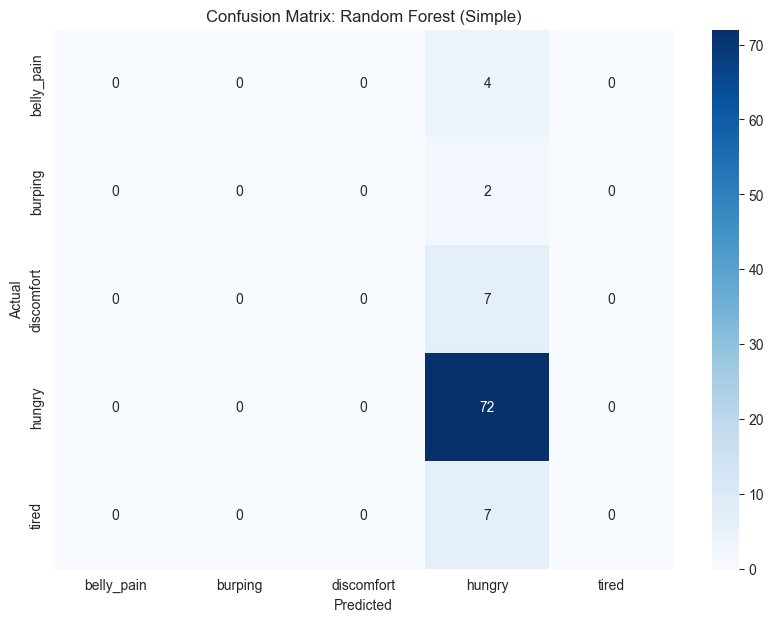

In [59]:
# Refit the model with the training data for confusion matrix and report
rf_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = rf_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest (Simple)')
plt.show()

4. AdaBoost model

In [63]:
# Initializing the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

In [64]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(ada_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

In [65]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.76
5-Fold Cross-Validation F1_weighted: 0.74
5-Fold Cross-Validation Precision_weighted: 0.74
5-Fold Cross-Validation Recall_weighted: 0.76


In [66]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["AdaBoost (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904


In [67]:
'''results_df=results_df.iloc[:-1]
results_df #delete last row'''

'results_df=results_df.iloc[:-1]\nresults_df #delete last row'

In [68]:
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      0.96      0.86        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.75        92
   macro avg       0.16      0.19      0.17        92
weighted avg       0.61      0.75      0.68        92



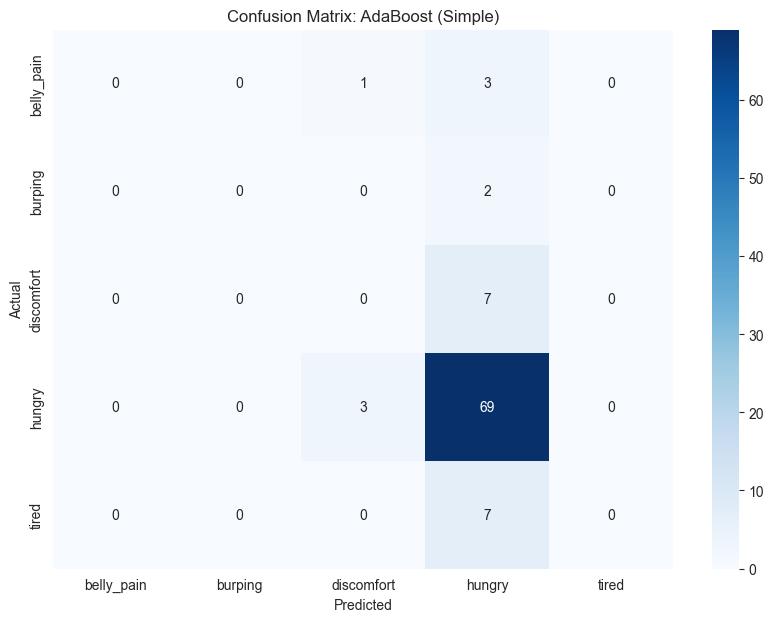

In [69]:
# Refit the model with the training data for confusion matrix and report
ada_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = ada_model.predict(X_mfcc_test)

# Print classification report
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: AdaBoost (Simple)')
plt.show()

5. XGBoost Model

In [71]:
# Initializing the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [72]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(xgb_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.84
5-Fold Cross-Validation F1_weighted: 0.78
5-Fold Cross-Validation Precision_weighted: 0.72
5-Fold Cross-Validation Recall_weighted: 0.84


In [73]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["XGBoost (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      1.00      0.88        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.78        92
   macro avg       0.16      0.20      0.18        92
weighted avg       0.61      0.78      0.69        92



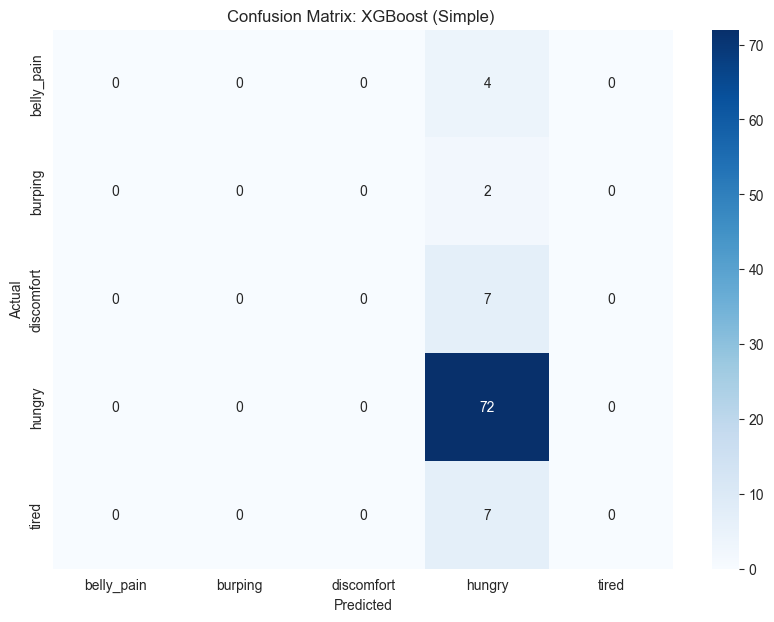

In [74]:
# Refit the model with the training data for confusion matrix and report
xgb_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = xgb_model.predict(X_mfcc_test)

# Print classification report
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: XGBoost (Simple) ')
plt.show()

6. LSTM

In [76]:
# Reshape X for LSTM (samples, time_steps, features)
X_lstm = X1.reshape(X1.shape[0], X1.shape[2], X1.shape[1])  


In [77]:
# One-hot encode labels
y_lstm = to_categorical(y1, num_classes=len(class_labels))

In [78]:
y_lstm.shape

(457, 5)

In [79]:
# Split the data into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42, stratify=y1)

In [80]:
y_test_lstm.shape

(138, 5)

In [81]:
y_train_lstm.shape

(319, 5)

In [82]:
# Define the LSTM model
lstm_model = Sequential()
# Add LSTM layer
lstm_model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))
# Add another LSTM layer
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.3))
# Add Dense layers
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
lstm_model.add(Dense(len(class_labels), activation='softmax'))
# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/50
10/10 [==============================] - 7s 358ms/step - loss: 1.3862 - accuracy: 0.4828 - val_loss: 0.9152 - val_accuracy: 0.8333
Epoch 2/50
10/10 [==============================] - 3s 320ms/step - loss: 0.9113 - accuracy: 0.8213 - val_loss: 0.7179 - val_accuracy: 0.8333
Epoch 3/50
10/10 [==============================] - 3s 285ms/step - loss: 0.7860 - accuracy: 0.8276 - val_loss: 0.6975 - val_accuracy: 0.8333
Epoch 4/50
10/10 [==============================] - 3s 287ms/step - loss: 0.8402 - accuracy: 0.8150 - val_loss: 0.6884 - val_accuracy: 0.8333
Epoch 5/50
10/10 [==============================] - 3s 279ms/step - loss: 0.7739 - accuracy: 0.8150 - val_loss: 0.6826 - val_accuracy: 0.8333
Epoch 6/50
10/10 [==============================] - 3s 284ms/step - loss: 0.7507 - accuracy: 0.8213 - val_loss: 0.6812 - val_accuracy: 0.8333
Epoch 7/50
10/10 [==============================] - 3s 316ms/step - loss: 0.7581 - accuracy: 0.8370 - val_loss: 0.6853 - val_accuracy: 0.8333
Epoch 

In [83]:
# Evaluate the model
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_lstm_ = np.argmax(y_test_lstm, axis=1)

5/5 [==============================] - 1s 57ms/step


In [84]:
# Accuracy
accuracy = accuracy_score(y_test_lstm_, y_pred_lstm)
f1 = f1_score(y_test_lstm_, y_pred_lstm, average='weighted')
precision = precision_score(y_test_lstm_, y_pred_lstm, average='weighted')
recall = recall_score(y_test_lstm_, y_pred_lstm, average='weighted')

In [85]:
new_row_cv = pd.DataFrame([["LSTM", accuracy , f1, precision,recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
'''
new_row_cv = pd.DataFrame([["LSTM", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])'''
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.20      0.12      0.15         8
      hungry       0.83      0.95      0.89       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.80       138
   macro avg       0.21      0.21      0.21       138
weighted avg       0.70      0.80      0.75       138



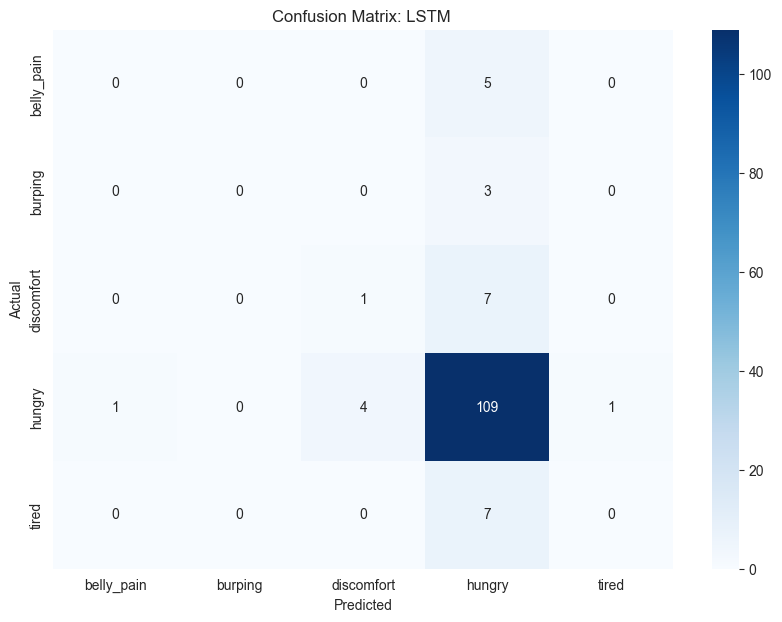

In [86]:
# Classification report
print(classification_report(y_test_lstm_, y_pred_lstm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_lstm_, y_pred_lstm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: LSTM ')
plt.show()

7. RNN

In [94]:
# Split the data into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42, stratify=y1)

In [95]:
# Define the RNN model
rnn_model = Sequential()

In [96]:
# Add SimpleRNN layer
rnn_model.add(SimpleRNN(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
rnn_model.add(Dropout(0.3))

In [97]:
# Add another SimpleRNN layer
rnn_model.add(SimpleRNN(64, return_sequences=False))
rnn_model.add(Dropout(0.3))



In [98]:
# Add Dense layers
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
rnn_model.add(Dense(len(class_labels), activation='softmax'))
# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [99]:
# Train the model
history = rnn_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/50
10/10 [==============================] - 2s 85ms/step - loss: 1.3894 - accuracy: 0.4326 - val_loss: 1.0428 - val_accuracy: 0.6667
Epoch 2/50
10/10 [==============================] - 1s 60ms/step - loss: 1.1376 - accuracy: 0.6082 - val_loss: 0.9567 - val_accuracy: 0.7391
Epoch 3/50
10/10 [==============================] - 1s 68ms/step - loss: 0.9805 - accuracy: 0.6865 - val_loss: 0.8591 - val_accuracy: 0.7899
Epoch 4/50
10/10 [==============================] - 1s 55ms/step - loss: 0.9157 - accuracy: 0.7304 - val_loss: 0.8137 - val_accuracy: 0.7971
Epoch 5/50
10/10 [==============================] - 1s 52ms/step - loss: 0.8172 - accuracy: 0.7524 - val_loss: 0.8001 - val_accuracy: 0.7971
Epoch 6/50
10/10 [==============================] - 1s 71ms/step - loss: 0.7721 - accuracy: 0.7774 - val_loss: 0.8038 - val_accuracy: 0.8116
Epoch 7/50
10/10 [==============================] - 1s 51ms/step - loss: 0.7580 - accuracy: 0.7994 - val_loss: 0.8018 - val_accuracy: 0.8116
Epoch 8/50
10

In [100]:
# Evaluate the model
y_pred_rnn = np.argmax(rnn_model.predict(X_test_lstm), axis=1)
y_test_rnn = np.argmax(y_test_lstm, axis=1)


5/5 [==============================] - 0s 35ms/step


In [101]:
# Accuracy
accuracy = accuracy_score(y_test_rnn, y_pred_rnn)
f1 = f1_score(y_test_rnn, y_pred_rnn, average='weighted')
precision = precision_score(y_test_rnn, y_pred_rnn, average='weighted')
recall = recall_score(y_test_rnn, y_pred_rnn, average='weighted')


In [102]:

new_row_cv = pd.DataFrame([["RNN", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         8
      hungry       0.84      0.97      0.90       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.80       138
   macro avg       0.17      0.19      0.18       138
weighted avg       0.70      0.80      0.75       138



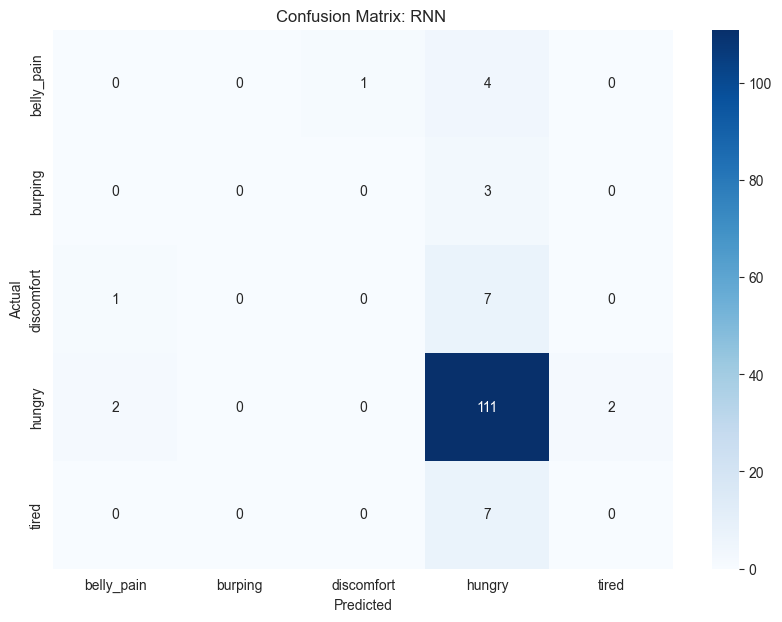

In [103]:
# Classification report
print(classification_report(y_test_rnn, y_pred_rnn, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_rnn, y_pred_rnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: RNN ')
plt.show()

8. CNN

In [104]:
timesteps = 6 
n_features = X_mfcc_train.shape[1] // timesteps  # Adjust n_features

# Reshaping data for CNN
X_mfcc_train_cnn = X_mfcc_train.reshape((X_mfcc_train.shape[0], timesteps, n_features))
X_mfcc_test_cnn = X_mfcc_test.reshape((X_mfcc_test.shape[0], timesteps, n_features))

# Check the shapes
print("Training data shape:", X_mfcc_train_cnn.shape)
print("Testing data shape:", X_mfcc_test_cnn.shape)

Training data shape: (365, 6, 377)
Testing data shape: (92, 6, 377)


In [105]:
# One-hot encode labels
num_classes = len(np.unique(y_mfcc_train))
y_train_cnn = to_categorical(y_mfcc_train, num_classes)
y_test_cnn = to_categorical(y_mfcc_test, num_classes)



In [106]:
# CNN Model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))




In [107]:
# Compile and Train the Model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_mfcc_train_cnn, y_train_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/20
10/10 - 1s - loss: 96.7042 - accuracy: 0.7295 - val_loss: 48.7566 - val_accuracy: 0.8082 - 699ms/epoch - 70ms/step
Epoch 2/20
10/10 - 0s - loss: 58.9922 - accuracy: 0.6404 - val_loss: 35.7298 - val_accuracy: 0.8082 - 63ms/epoch - 6ms/step
Epoch 3/20
10/10 - 0s - loss: 18.7383 - accuracy: 0.6918 - val_loss: 12.7944 - val_accuracy: 0.7534 - 79ms/epoch - 8ms/step
Epoch 4/20
10/10 - 0s - loss: 13.0873 - accuracy: 0.7603 - val_loss: 14.3053 - val_accuracy: 0.7671 - 63ms/epoch - 6ms/step
Epoch 5/20
10/10 - 0s - loss: 10.3826 - accuracy: 0.7226 - val_loss: 11.2091 - val_accuracy: 0.7671 - 63ms/epoch - 6ms/step
Epoch 6/20
10/10 - 0s - loss: 7.9150 - accuracy: 0.7911 - val_loss: 13.6412 - val_accuracy: 0.7945 - 72ms/epoch - 7ms/step
Epoch 7/20
10/10 - 0s - loss: 8.6513 - accuracy: 0.7295 - val_loss: 10.2241 - val_accuracy: 0.7534 - 64ms/epoch - 6ms/step
Epoch 8/20
10/10 - 0s - loss: 4.8673 - accuracy: 0.8253 - val_loss: 11.3511 - val_accuracy: 0.7808 - 64ms/epoch - 6ms/step
Epoch 9/2

In [108]:
# Make predictions on the test data
y_pred_cnn = cnn_model.predict(X_mfcc_test_cnn)
# Convert predictions and true labels from one-hot encoded format to class labels
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true_classes_cnn = np.argmax(y_test_cnn, axis=1)


3/3 [==============================] - 0s 8ms/step


In [109]:
# Generate a classification report
print(classification_report(y_true_classes_cnn, y_pred_classes_cnn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         7
           3       0.78      0.94      0.86        72
           4       0.00      0.00      0.00         7

    accuracy                           0.74        92
   macro avg       0.16      0.19      0.17        92
weighted avg       0.61      0.74      0.67        92



In [110]:
# Accuracy
accuracy = accuracy_score(y_true_classes_cnn, y_pred_classes_cnn)

# F1 Score
f1 = f1_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Precision
precision = precision_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Recall
recall = recall_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

In [111]:
new_row_cv = pd.DataFrame([["CNN", accuracy , f1, precision,recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130


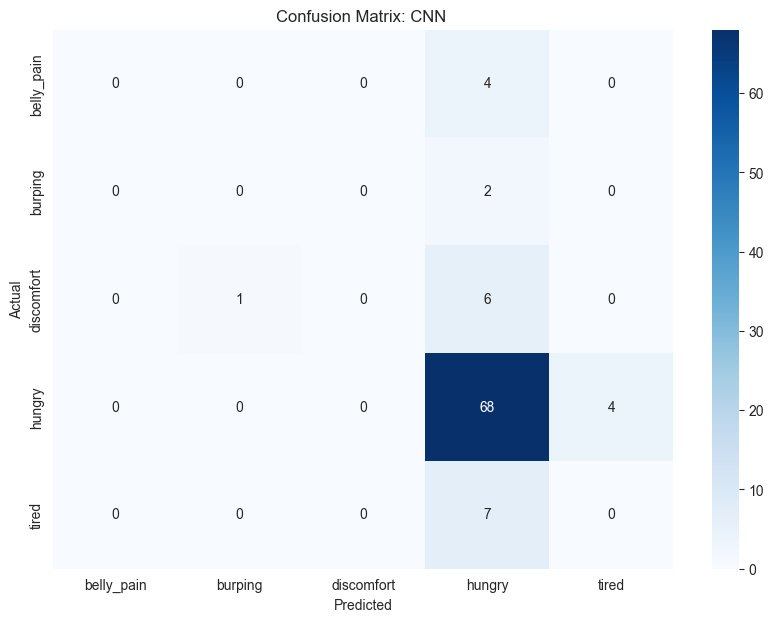

In [112]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes_cnn, y_pred_classes_cnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN ')
plt.show()

9. CNN-XGBoost

In [113]:
# Define the CNN model up to the Flatten layer
cnn_xg_model = Sequential()
cnn_xg_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_xg_model.add(MaxPooling1D(pool_size=2))
cnn_xg_model.add(Flatten())  # Feature extraction layer
cnn_xg_model.add(Dropout(0.5))

# Convert to a feature-extractor model that stops at the Flatten layer
feature_extractor = Model(inputs=cnn_xg_model.input, outputs=cnn_xg_model.layers[-2].output)

In [114]:
# Extract features from training and test data
X_train_features = feature_extractor.predict(X_mfcc_train_cnn)
X_test_features = feature_extractor.predict(X_mfcc_test_cnn)


3/3 [==============================] - 0s 0s/step


In [117]:
# Initialize and train the XGBoost classifier
xgb_cnn_model = XGBClassifier(objective='multi:softmax', num_class=num_classes, eval_metric='mlogloss')
xgb_cnn_model.fit(X_train_features, y_mfcc_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [118]:
# Make predictions with XGBoost
y_pred_xgb_cnn = xgb_cnn_model.predict(X_test_features)

In [119]:
new_row_cv = pd.DataFrame([["CNN-XGBoost", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130


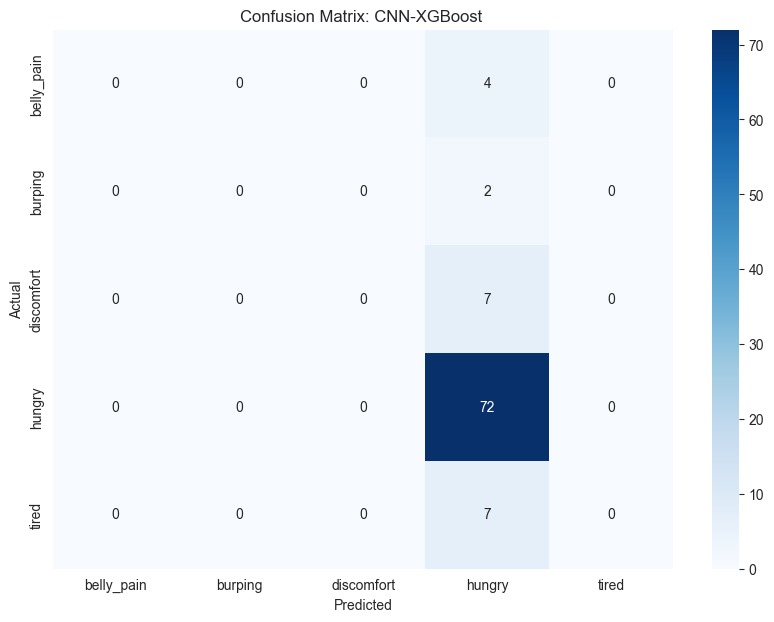

In [120]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_xgb_cnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN-XGBoost ')
plt.show()

10.CNN-LSTM

In [121]:
# CNN-LSTM Model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(64, activation='relu'))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(Dense(num_classes, activation='softmax'))

In [122]:
# Compile and Train the Model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_lstm_model.fit(X_mfcc_train_cnn, y_train_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/20
10/10 - 4s - loss: 14.0101 - accuracy: 0.5411 - val_loss: 8.3989 - val_accuracy: 0.8082 - 4s/epoch - 444ms/step
Epoch 2/20
10/10 - 0s - loss: 8.6538 - accuracy: 0.7158 - val_loss: 6.5950 - val_accuracy: 0.7945 - 78ms/epoch - 8ms/step
Epoch 3/20
10/10 - 0s - loss: 4.0973 - accuracy: 0.7842 - val_loss: 2.3990 - val_accuracy: 0.7671 - 79ms/epoch - 8ms/step
Epoch 4/20
10/10 - 0s - loss: 2.4178 - accuracy: 0.7500 - val_loss: 1.5992 - val_accuracy: 0.7808 - 94ms/epoch - 9ms/step
Epoch 5/20
10/10 - 0s - loss: 1.5422 - accuracy: 0.8185 - val_loss: 1.4892 - val_accuracy: 0.7945 - 67ms/epoch - 7ms/step
Epoch 6/20
10/10 - 0s - loss: 1.7437 - accuracy: 0.8562 - val_loss: 1.0405 - val_accuracy: 0.8082 - 78ms/epoch - 8ms/step
Epoch 7/20
10/10 - 0s - loss: 1.2249 - accuracy: 0.8562 - val_loss: 1.3998 - val_accuracy: 0.8082 - 79ms/epoch - 8ms/step
Epoch 8/20
10/10 - 0s - loss: 1.5876 - accuracy: 0.8493 - val_loss: 1.1454 - val_accuracy: 0.8082 - 110ms/epoch - 11ms/step
Epoch 9/20
10/10 - 0s

In [123]:
# Make predictions on the test data
y_pred_cnn_lstm = cnn_lstm_model.predict(X_mfcc_test_cnn)

# Convert predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred_cnn_lstm, axis=1)
y_true_classes = np.argmax(y_test_cnn, axis=1)


3/3 [==============================] - 0s 7ms/step


In [124]:
# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7826
F1 Score: 0.6872
Precision: 0.6125
Recall: 0.7826


In [125]:
new_row_cv = pd.DataFrame([["CNN-LSTM", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


11. Ensemble learning

In [126]:
timesteps = 1
n_features = X_mfcc_train.shape[1] # Adjust n_features

# Reshaping data for CNN
X_mfcc_train_cnn = X_mfcc_train.reshape((X_mfcc_train.shape[0], timesteps, n_features))
X_mfcc_test_cnn = X_mfcc_test.reshape((X_mfcc_test.shape[0], timesteps, n_features))

# Check the shapes
print("Training data shape:", X_mfcc_train_cnn.shape)
print("Testing data shape:", X_mfcc_test_cnn.shape)

Training data shape: (365, 1, 2262)
Testing data shape: (92, 1, 2262)


In [127]:
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical if they are not already
num_classes = len(np.unique(y_mfcc_train))
y_mfcc_train_categorical = to_categorical(y_mfcc_train, num_classes=num_classes)

# Step 2: Define a CNN model for feature extraction
en_cnn_model = Sequential()
en_cnn_model.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
en_cnn_model.add(MaxPooling1D(pool_size=1))
en_cnn_model.add(Flatten())
en_cnn_model.add(Dense(128, activation='relu'))  # Intermediate dense layer if needed
en_cnn_model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class

# Compile and train the CNN model
en_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
en_cnn_model.fit(X_mfcc_train_cnn, y_mfcc_train_categorical, epochs=20, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/20
10/10 - 1s - loss: 43.4988 - accuracy: 0.6541 - val_loss: 73.8922 - val_accuracy: 0.7671 - 760ms/epoch - 76ms/step
Epoch 2/20
10/10 - 0s - loss: 35.0059 - accuracy: 0.7808 - val_loss: 35.8470 - val_accuracy: 0.5890 - 60ms/epoch - 6ms/step
Epoch 3/20
10/10 - 0s - loss: 15.7231 - accuracy: 0.7363 - val_loss: 32.5464 - val_accuracy: 0.8082 - 47ms/epoch - 5ms/step
Epoch 4/20
10/10 - 0s - loss: 13.9768 - accuracy: 0.7945 - val_loss: 21.6468 - val_accuracy: 0.7123 - 63ms/epoch - 6ms/step
Epoch 5/20
10/10 - 0s - loss: 11.4573 - accuracy: 0.7397 - val_loss: 14.6868 - val_accuracy: 0.7260 - 47ms/epoch - 5ms/step
Epoch 6/20
10/10 - 0s - loss: 6.3244 - accuracy: 0.7432 - val_loss: 11.2907 - val_accuracy: 0.7397 - 63ms/epoch - 6ms/step
Epoch 7/20
10/10 - 0s - loss: 8.5613 - accuracy: 0.8082 - val_loss: 15.9462 - val_accuracy: 0.7123 - 75ms/epoch - 7ms/step
Epoch 8/20
10/10 - 0s - loss: 6.9035 - accuracy: 0.7637 - val_loss: 14.9548 - val_accuracy: 0.7808 - 47ms/epoch - 5ms/step
Epoch 9/2

In [128]:

# Step 3: Extract CNN features
train_features = en_cnn_model.predict(X_mfcc_train_cnn)
test_features = en_cnn_model.predict(X_mfcc_test_cnn)

3/3 [==============================] - 0s 0s/step


In [129]:
# Step 4: Define base classifiers and meta-classifier for stacking
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='linear', probability=True)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
]


In [130]:
y_mfcc_train.shape

(365,)

In [131]:
# Meta-classifier (KNN)
meta_learner = KNeighborsClassifier(n_neighbors=5)

# Step 5: Create a stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Train the stacking classifier
stacking_clf.fit(train_features, y_mfcc_train)

# Step 6: Make predictions with the stacking model
y_pred_stacking = stacking_clf.predict(test_features)



In [132]:
# Step 7: Evaluate the model
accuracy = accuracy_score(y_mfcc_test, y_pred_stacking)
f1 = f1_score(y_mfcc_test, y_pred_stacking, average='weighted')
precision = precision_score(y_mfcc_test, y_pred_stacking, average='weighted')
recall = recall_score(y_mfcc_test, y_pred_stacking, average='weighted')

print(f'Ensemble Accuracy: {accuracy * 100:.2f}%')
print(f'Ensemble F1 Score: {f1:.2f}')
print(f'Ensemble Precision: {precision:.2f}')
print(f'Ensemble Recall: {recall:.2f}')

Ensemble Accuracy: 76.09%
Ensemble F1 Score: 0.68
Ensemble Precision: 0.61
Ensemble Recall: 0.76


In [133]:
new_row_cv = pd.DataFrame([["Ensemble Model(CNN,RandomForest,XGBoost,SVM,KNN)", accuracy , f1, precision,recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df



,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


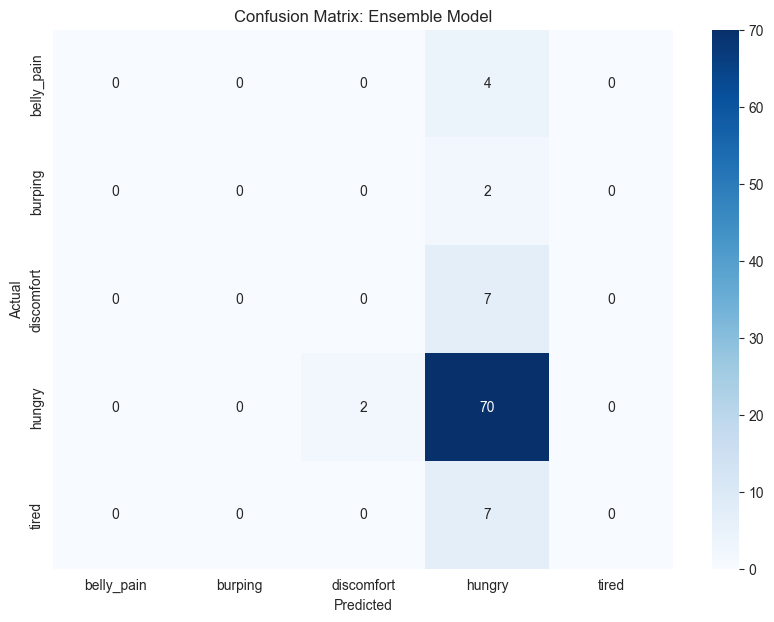

In [134]:
cm = confusion_matrix(y_mfcc_test, y_pred_stacking)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Ensemble Model')
plt.show()

## Handling Data imbalance with SMOTE

In [135]:
# the number of samples per class before applying SMOTE
print(f"Original class distribution: {Counter(y_mfcc_train)}")


Original class distribution: Counter({3: 310, 2: 20, 4: 17, 0: 12, 1: 6})


In [136]:
# Applying SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_mfcc_train, y_mfcc_train)

In [137]:
# the number of samples per class after oversampling
print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")

Class distribution after SMOTE: Counter({1: 310, 3: 310, 2: 310, 4: 310, 0: 310})


11. SVM with SMOTE

In [138]:
# Initializing the SVM model with SMOTE

svm_model_smote = SVC(kernel='linear', random_state=42)
# Define a list of scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}


In [139]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(svm_model_smote, X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')




5-Fold Cross-Validation Accuracy: 0.98
5-Fold Cross-Validation F1_weighted: 0.98
5-Fold Cross-Validation Precision_weighted: 0.98
5-Fold Cross-Validation Recall_weighted: 0.98


In [140]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["SVM with SMOTE", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)




In [141]:
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [142]:
# Refit the model with the training data for confusion matrix and report
svm_model_smote.fit(X_train_resampled, y_train_resampled)
# Making predictions
y_pred_smote = svm_model_smote.predict(X_mfcc_test)
# Print classification report
print(classification_report(y_mfcc_test, y_pred_smote, target_names=class_labels))


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.25      0.14      0.18         7
      hungry       0.81      0.85      0.83        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.67        92
   macro avg       0.21      0.20      0.20        92
weighted avg       0.66      0.67      0.66        92



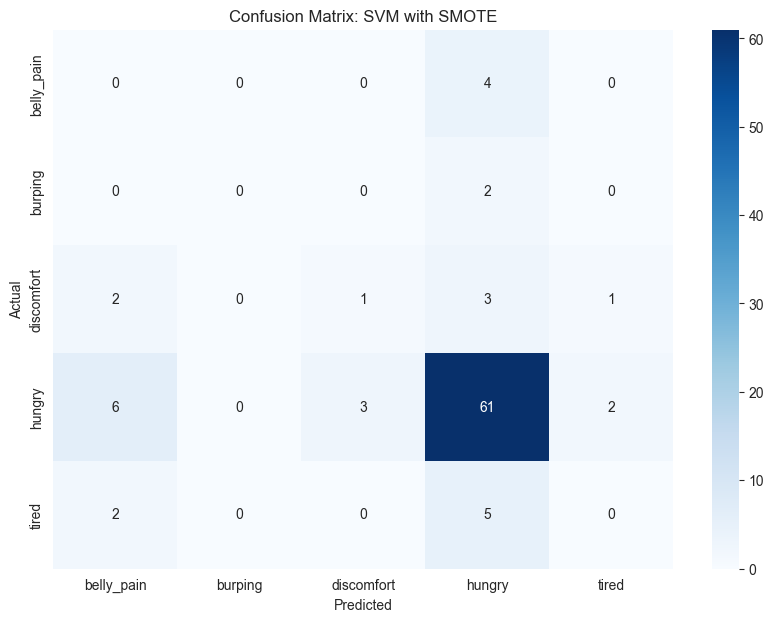

In [143]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM with SMOTE')
plt.show()

12. KNN with SMOTE

In [144]:
# Step 1: Initialize the KNN model
knn_model_smote = KNeighborsClassifier(n_neighbors=5) 

In [145]:
# Step 2: Applying 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(knn_model_smote,X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

In [146]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.84
5-Fold Cross-Validation F1_weighted: 0.80
5-Fold Cross-Validation Precision_weighted: 0.87
5-Fold Cross-Validation Recall_weighted: 0.84


In [147]:
# Step 3: Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["KNN with SMOTE", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [148]:
# Refit the model with the training data for confusion matrix and report
knn_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_knn_smote = knn_model_smote.predict(X_mfcc_test)

In [149]:
# Print classification report
print(classification_report(y_mfcc_test, y_pred_knn_smote, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.05      0.25      0.08         4
     burping       0.11      0.50      0.18         2
  discomfort       0.10      0.29      0.15         7
      hungry       0.78      0.25      0.38        72
       tired       0.10      0.29      0.15         7

    accuracy                           0.26        92
   macro avg       0.23      0.31      0.19        92
weighted avg       0.63      0.26      0.33        92



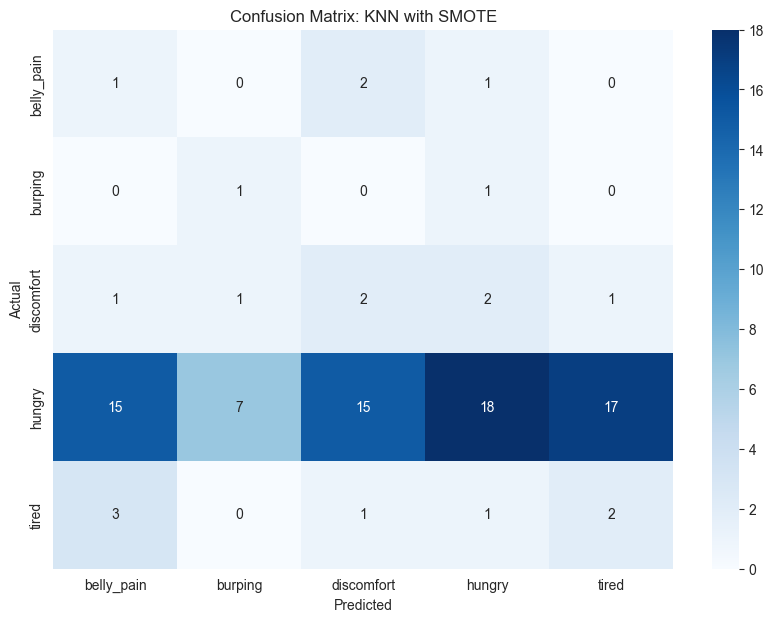

In [150]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_knn_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: KNN with SMOTE')
plt.show()

13. Random Forest with SMOTE

In [151]:
# Random Forest with SMOTE
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)

In [152]:
# Step 2: Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(rf_model_smote ,X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 1.00
5-Fold Cross-Validation F1_weighted: 1.00
5-Fold Cross-Validation Precision_weighted: 1.00
5-Fold Cross-Validation Recall_weighted: 1.00


In [153]:
# Step 3: Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["Random Forest with SMOTE", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [154]:
# Refit the model with the training data for confusion matrix and report
rf_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_rf_smote = rf_model_smote.predict(X_mfcc_test)

# Print classification report
print(classification_report(y_mfcc_test, y_pred_rf_smote, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.79      0.99      0.88        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.77        92
   macro avg       0.16      0.20      0.18        92
weighted avg       0.62      0.77      0.69        92



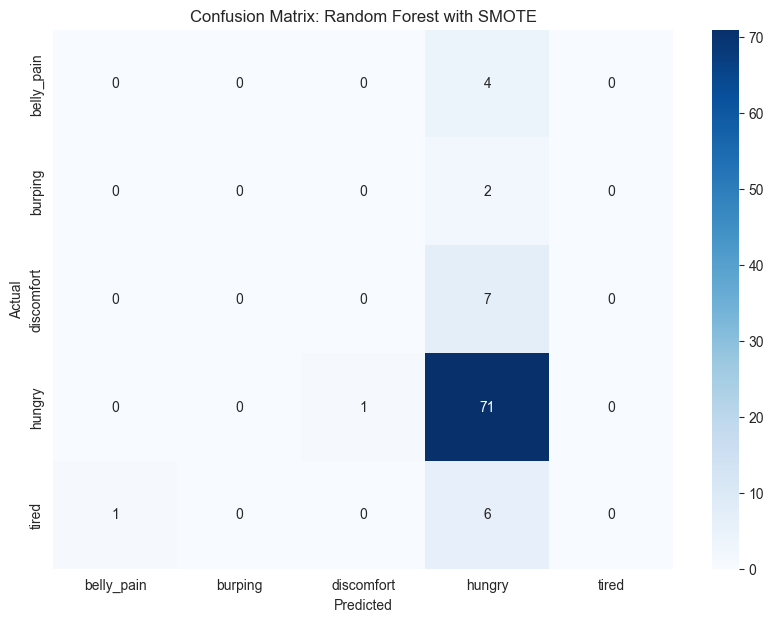

In [155]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_rf_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest with SMOTE')
plt.show()

15. AdaBoost model

In [156]:
# Initializing the AdaBoost model with SMOTE
ada_model_smote = AdaBoostClassifier(n_estimators=100, random_state=42)

In [157]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(ada_model_smote, X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.29
5-Fold Cross-Validation F1_weighted: 0.21
5-Fold Cross-Validation Precision_weighted: 0.26
5-Fold Cross-Validation Recall_weighted: 0.29


In [158]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["AdaBoost with SMOTE", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [159]:
# Refit the model with the training data for confusion matrix and report
ada_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_ada_smote = ada_model_smote.predict(X_mfcc_test)

In [160]:
# Print classification report
print(classification_report(y_mfcc_test, y_pred_ada_smote, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.04      0.75      0.08         4
     burping       0.00      0.00      0.00         2
  discomfort       0.12      0.29      0.17         7
      hungry       0.00      0.00      0.00        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.05        92
   macro avg       0.03      0.21      0.05        92
weighted avg       0.01      0.05      0.02        92



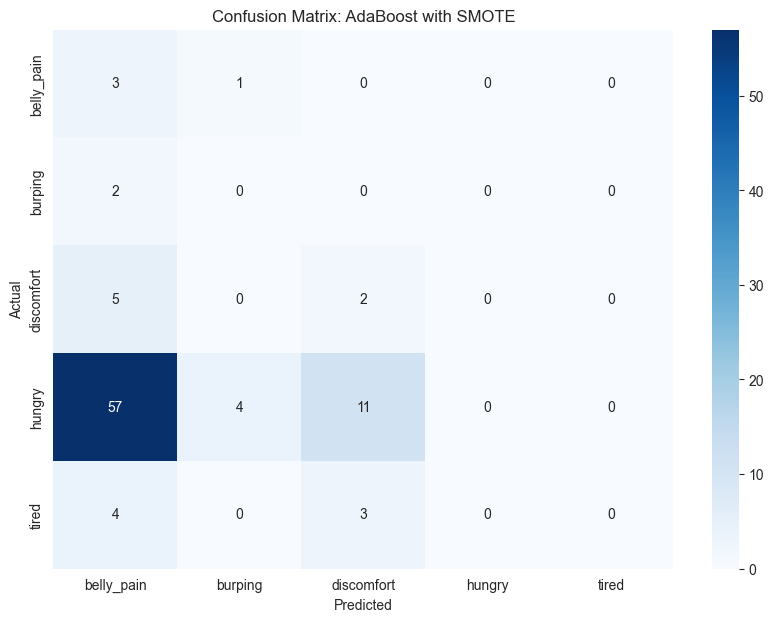

In [161]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_ada_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: AdaBoost with SMOTE')
plt.show()

16.XGBoost Model

In [162]:
# Initializing the XGBoost model
xgb_model_smote = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [163]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(xgb_model_smote, X_train_resampled, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.99
5-Fold Cross-Validation F1_weighted: 0.99
5-Fold Cross-Validation Precision_weighted: 0.99
5-Fold Cross-Validation Recall_weighted: 0.99


In [164]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["XGBoost with SMOTE", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [165]:
# Refit the model with the training data for confusion matrix and report
xgb_model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_xgb_smote = xgb_model_smote.predict(X_mfcc_test)

In [166]:
# Print classification report
print(classification_report(y_mfcc_test, y_pred_xgb_smote, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      0.97      0.86        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.76        92
   macro avg       0.16      0.19      0.17        92
weighted avg       0.61      0.76      0.68        92



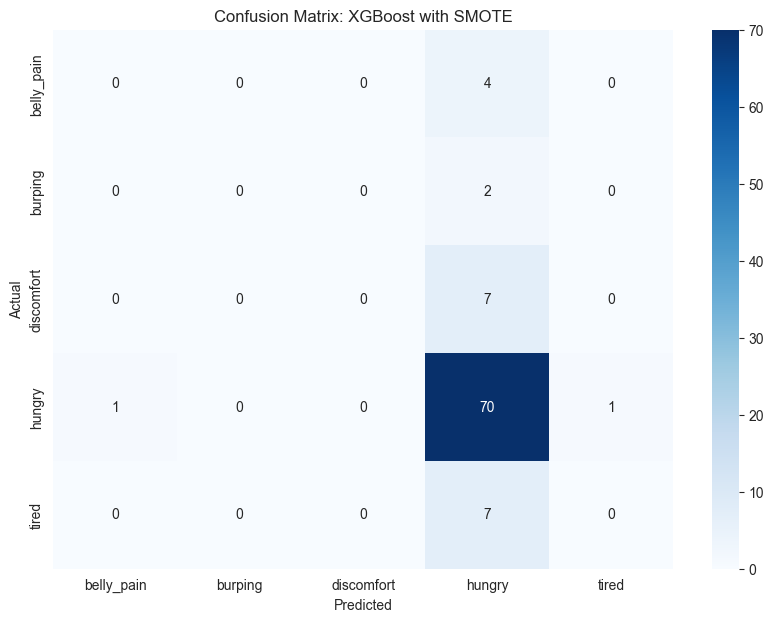

In [167]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_xgb_smote)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: XGBoost with SMOTE')
plt.show()

17. LSTM with SMOTE

In [168]:
# Flatten the training data for SMOTE
timesteps = X_train_lstm.shape[1]  # 174
features = X_train_lstm.shape[2]   # 13
X_train_lstm_flat = X_train_lstm.reshape(X_train_lstm.shape[0], timesteps * features)  # Shape: (samples, timesteps * features)

In [169]:
y_train_lstm.shape

(319, 5)

In [170]:
# Apply SMOTE
smote = SMOTE(random_state=42,k_neighbors=1)
X_train_lstm_resampled, y_train_lstm_resampled = smote.fit_resample(X_train_lstm_flat, y_train_lstm )

In [171]:
y_train_lstm.shape

(319, 5)

In [172]:
# the number of samples per class before applying SMOTE
y_train_1d = np.argmax(y_train_lstm, axis=1)
print(f"Original class distribution before SMOTE: {Counter(y_train_1d)}")

# the number of samples per class after applying SMOTE
y_train_1d=np.argmax(y_train_lstm_resampled, axis=1)
print(f"Original class distribution after SMOTE: {Counter(y_train_1d)}")


Original class distribution before SMOTE: Counter({3: 267, 2: 19, 4: 17, 0: 11, 1: 5})
Original class distribution after SMOTE: Counter({3: 267, 2: 267, 0: 267, 1: 267, 4: 267})


In [173]:
y_train_1d.shape

(1335,)

In [174]:
X_train_lstm_resampled.shape

(1335, 2262)

In [175]:
# Reshape back to 3D for LSTM
X_train_resampled_lstm = X_train_lstm_resampled.reshape(X_train_lstm_resampled.shape[0], timesteps, features)


In [176]:
# Check label shapes
print("y_train_resampled_lstm shape:", y_train_lstm_resampled.shape)  
print("y_test_lstm shape:", y_test_lstm.shape)  

y_train_resampled_lstm shape: (1335, 5)
y_test_lstm shape: (138, 5)


In [177]:
lstm_model = Sequential()
# Add LSTM layer
lstm_model.add(LSTM(128, input_shape=(X_train_resampled_lstm.shape[1], X_train_resampled_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))
# Add another LSTM layer, ensure it doesn't return sequences
lstm_model.add(LSTM(64, return_sequences=False))  # Final LSTM layer does not return sequences
lstm_model.add(Dropout(0.3))
# Add Dense layers
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
lstm_model.add(Dense(len(class_labels), activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [178]:
# Train the model
history = lstm_model.fit(
    X_train_resampled_lstm, y_train_lstm_resampled,
    epochs=50, batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm)
)

Epoch 1/50
42/42 [==============================] - 13s 242ms/step - loss: 1.4350 - accuracy: 0.3783 - val_loss: 1.6501 - val_accuracy: 0.1812
Epoch 2/50
42/42 [==============================] - 10s 229ms/step - loss: 0.8135 - accuracy: 0.7146 - val_loss: 1.2993 - val_accuracy: 0.3913
Epoch 3/50
42/42 [==============================] - 9s 226ms/step - loss: 0.4509 - accuracy: 0.8419 - val_loss: 1.0170 - val_accuracy: 0.6594
Epoch 4/50
42/42 [==============================] - 9s 227ms/step - loss: 0.2764 - accuracy: 0.9109 - val_loss: 1.3484 - val_accuracy: 0.4928
Epoch 5/50
42/42 [==============================] - 10s 228ms/step - loss: 0.1845 - accuracy: 0.9393 - val_loss: 1.0161 - val_accuracy: 0.7464
Epoch 6/50
42/42 [==============================] - 10s 230ms/step - loss: 0.1626 - accuracy: 0.9498 - val_loss: 1.2825 - val_accuracy: 0.7174
Epoch 7/50
42/42 [==============================] - 9s 221ms/step - loss: 0.1255 - accuracy: 0.9633 - val_loss: 1.3612 - val_accuracy: 0.6667
Ep

In [179]:
# Evaluate the model
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_lstm_ = np.argmax(y_test_lstm, axis=1)

5/5 [==============================] - 1s 117ms/step


In [180]:
#Evaluation Model
accuracy = accuracy_score(y_test_lstm_, y_pred_lstm)
f1 = f1_score(y_test_lstm_, y_pred_lstm, average='weighted')
precision = precision_score(y_test_lstm_, y_pred_lstm, average='weighted')
recall = recall_score(y_test_lstm_, y_pred_lstm, average='weighted')


In [181]:
new_row_cv = pd.DataFrame([["LSTM with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [182]:
# Classification report
print(classification_report(y_test_lstm_, y_pred_lstm, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.25      0.20      0.22         5
     burping       0.00      0.00      0.00         3
  discomfort       0.09      0.12      0.11         8
      hungry       0.84      0.87      0.85       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.74       138
   macro avg       0.24      0.24      0.24       138
weighted avg       0.71      0.74      0.73       138



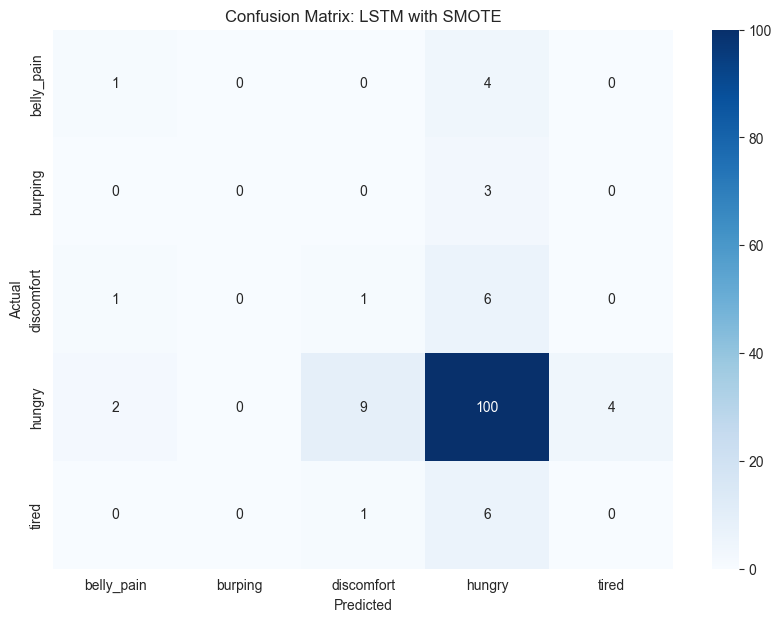

In [183]:

# Confusion Matrix
cm = confusion_matrix(y_test_lstm_, y_pred_lstm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: LSTM with SMOTE')
plt.show()

18. RNN with SMOTE

In [184]:
# Define the RNN model
rnn_model_smote = Sequential()

In [185]:
# Add SimpleRNN layer
rnn_model_smote.add(SimpleRNN(128, input_shape=(X_train_resampled_lstm.shape[1], X_train_resampled_lstm.shape[2]), return_sequences=True))
rnn_model_smote.add(Dropout(0.3))
# Add another SimpleRNN layer
rnn_model_smote.add(SimpleRNN(64, return_sequences=False))
rnn_model_smote.add(Dropout(0.3))

# Add Dense layers
rnn_model_smote.add(Dense(32, activation='relu'))
rnn_model_smote.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
rnn_model_smote.add(Dense(len(class_labels), activation='softmax'))
# Compile the model
rnn_model_smote.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [186]:
# Train the model
history = rnn_model_smote.fit(X_train_resampled_lstm, y_train_lstm_resampled, epochs=50, batch_size=32,
                        validation_data=(X_test_lstm, y_test_lstm))


Epoch 1/50
42/42 [==============================] - 9s 114ms/step - loss: 1.5130 - accuracy: 0.3655 - val_loss: 1.7726 - val_accuracy: 0.0870
Epoch 2/50
42/42 [==============================] - 5s 111ms/step - loss: 1.1693 - accuracy: 0.5281 - val_loss: 1.7712 - val_accuracy: 0.1377
Epoch 3/50
42/42 [==============================] - 4s 106ms/step - loss: 0.9418 - accuracy: 0.6472 - val_loss: 1.6620 - val_accuracy: 0.2319
Epoch 4/50
42/42 [==============================] - 4s 107ms/step - loss: 0.6919 - accuracy: 0.7558 - val_loss: 1.6276 - val_accuracy: 0.2681
Epoch 5/50
42/42 [==============================] - 5s 110ms/step - loss: 0.6027 - accuracy: 0.7820 - val_loss: 1.5053 - val_accuracy: 0.3768
Epoch 6/50
42/42 [==============================] - 3s 83ms/step - loss: 0.5549 - accuracy: 0.7813 - val_loss: 1.4341 - val_accuracy: 0.3986
Epoch 7/50
42/42 [==============================] - 4s 86ms/step - loss: 0.4470 - accuracy: 0.8315 - val_loss: 1.3943 - val_accuracy: 0.4130
Epoch 8/

In [187]:
# Evaluate the model
y_pred_rnn_s = np.argmax(rnn_model_smote.predict(X_test_lstm), axis=1)
y_test_rnn_s = np.argmax(y_test_lstm, axis=1)

5/5 [==============================] - 0s 16ms/step


In [188]:
# Accuracy
accuracy = accuracy_score(y_test_rnn_s, y_pred_rnn_s)
f1 = f1_score(y_test_rnn_s, y_pred_rnn_s, average='weighted')
precision = precision_score(y_test_rnn_s, y_pred_rnn_s, average='weighted')
recall = recall_score(y_test_rnn_s, y_pred_rnn_s, average='weighted')

new_row_cv = pd.DataFrame([["RNN with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [189]:
# Classification report
print(classification_report(y_test_rnn_s, y_pred_rnn_s, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.20      0.25      0.22         8
      hungry       0.82      0.77      0.80       115
       tired       0.07      0.14      0.10         7

    accuracy                           0.67       138
   macro avg       0.22      0.23      0.22       138
weighted avg       0.70      0.67      0.68       138



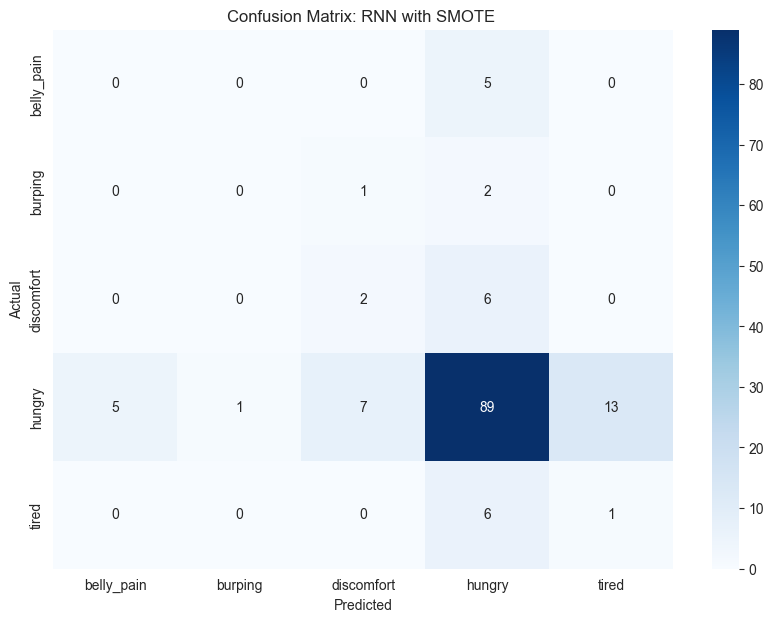

In [190]:
# Confusion Matrix
cm = confusion_matrix(y_test_rnn_s, y_pred_rnn_s)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: RNN with SMOTE ')
plt.show()

19. CNN with SMOTE

In [191]:
timesteps = 6
n_features = X_train_resampled.shape[1] // timesteps  # Adjust n_features


In [192]:
# Reshape the resampled data for CNN
X_train_resampled_cnn = X_train_resampled.reshape((X_train_resampled.shape[0], timesteps, n_features))
X_mfcc_test_cnn = X_mfcc_test.reshape((X_mfcc_test.shape[0], timesteps, n_features))
# Check the shape
print("Resampled training data shape:", X_train_resampled_cnn.shape)
print("Resampled testing data shape:",X_mfcc_test_cnn.shape)


Resampled training data shape: (1550, 6, 377)
Resampled testing data shape: (92, 6, 377)


In [193]:
# One-hot encode resampled labels
y_train_resampled_cnn = to_categorical(y_train_resampled, num_classes=len(class_labels))


In [194]:
y_train_resampled_cnn.shape

(1550, 5)

In [195]:
# CNN Model
cnn_model_s = Sequential()
cnn_model_s.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_model_s.add(MaxPooling1D(pool_size=2))
cnn_model_s.add(Flatten())
cnn_model_s.add(Dropout(0.5))
cnn_model_s.add(Dense(len(class_labels), activation='softmax'))

In [196]:
# Compile the model (if not already compiled)
cnn_model_s.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model with the resampled data
cnn_model_s.fit(X_train_resampled_cnn, y_train_resampled_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/20
39/39 - 1s - loss: 34.9090 - accuracy: 0.4790 - val_loss: 60.9029 - val_accuracy: 0.0484 - 1s/epoch - 33ms/step
Epoch 2/20
39/39 - 0s - loss: 3.8389 - accuracy: 0.7355 - val_loss: 28.2198 - val_accuracy: 0.0710 - 189ms/epoch - 5ms/step
Epoch 3/20
39/39 - 0s - loss: 1.5323 - accuracy: 0.7919 - val_loss: 25.5536 - val_accuracy: 0.0839 - 189ms/epoch - 5ms/step
Epoch 4/20
39/39 - 0s - loss: 1.4573 - accuracy: 0.8298 - val_loss: 15.6634 - val_accuracy: 0.0613 - 188ms/epoch - 5ms/step
Epoch 5/20
39/39 - 0s - loss: 1.0184 - accuracy: 0.8484 - val_loss: 10.0829 - val_accuracy: 0.1161 - 189ms/epoch - 5ms/step
Epoch 6/20
39/39 - 0s - loss: 0.9353 - accuracy: 0.8411 - val_loss: 5.2316 - val_accuracy: 0.2355 - 197ms/epoch - 5ms/step
Epoch 7/20
39/39 - 0s - loss: 0.7645 - accuracy: 0.8750 - val_loss: 9.6594 - val_accuracy: 0.1452 - 198ms/epoch - 5ms/step
Epoch 8/20
39/39 - 0s - loss: 0.6398 - accuracy: 0.8782 - val_loss: 7.9723 - val_accuracy: 0.1355 - 219ms/epoch - 6ms/step
Epoch 9/20
3

In [197]:
X_mfcc_test_cnn.shape

(92, 6, 377)

In [198]:
# Make predictions on the test data
y_pred_cnn = cnn_model_s.predict(X_mfcc_test_cnn)
# Convert predictions and true labels from one-hot encoded format to class labels
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true_classes_cnn = np.argmax(y_test_cnn, axis=1)

3/3 [==============================] - 0s 0s/step


In [199]:
# Generate a classification report
print(classification_report(y_true_classes_cnn, y_pred_classes_cnn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         7
           3       0.78      0.96      0.86        72
           4       0.00      0.00      0.00         7

    accuracy                           0.75        92
   macro avg       0.16      0.19      0.17        92
weighted avg       0.61      0.75      0.68        92



In [200]:
# Accuracy
accuracy = accuracy_score(y_true_classes_cnn, y_pred_classes_cnn)

# F1 Score
f1 = f1_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Precision
precision = precision_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Recall
recall = recall_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

new_row_cv = pd.DataFrame([["CNN with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


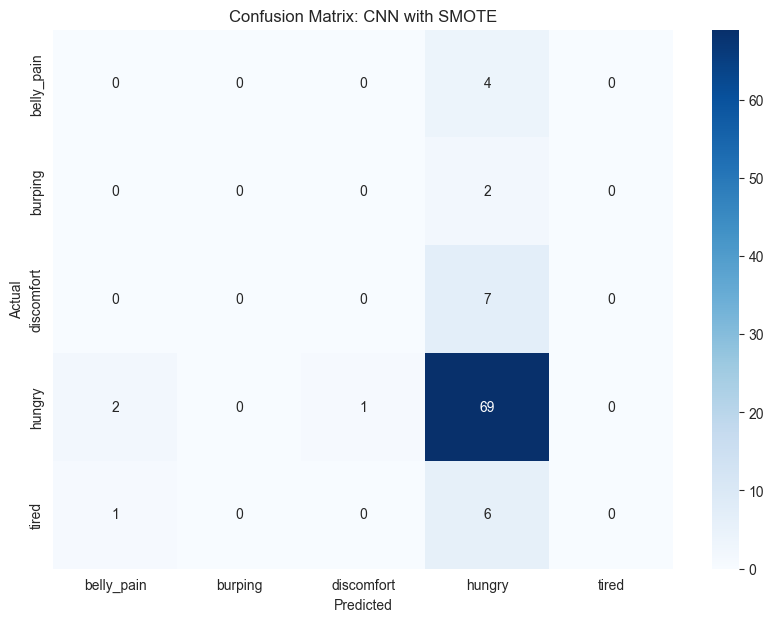

In [201]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes_cnn, y_pred_classes_cnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN with SMOTE')
plt.show()

20. CNN-XGBoost with SMOTE

In [202]:
# Define the CNN model up to the Flatten layer
cnn_xg_model = Sequential()
cnn_xg_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_xg_model.add(MaxPooling1D(pool_size=2))
cnn_xg_model.add(Flatten())  # Feature extraction layer
cnn_xg_model.add(Dropout(0.5))

In [203]:
# Convert to a feature-extractor model that stops at the Flatten layer
feature_extractor = Model(inputs=cnn_xg_model.input, outputs=cnn_xg_model.layers[-2].output)

In [204]:
# Extract features from training and test data
X_train_features = feature_extractor.predict(X_train_resampled_cnn)
X_test_features = feature_extractor.predict(X_mfcc_test_cnn)

3/3 [==============================] - 0s 8ms/step


In [205]:
xgb_model_1 = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(xgb_model_1, X_train_features, y_train_resampled, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

In [206]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.98
5-Fold Cross-Validation F1_weighted: 0.98
5-Fold Cross-Validation Precision_weighted: 0.98
5-Fold Cross-Validation Recall_weighted: 0.98


In [207]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["CNN-XGBoost with SMOTE", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


In [208]:
# Refit the model with the training data for confusion matrix and report
xgb_model_1.fit(X_train_features, y_train_resampled)
y_pred_xgb = xgb_model_1.predict(X_test_features)

In [209]:
# Print classification report
print(classification_report(y_mfcc_test, y_pred_xgb, target_names=class_labels))

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.25      0.14      0.18         7
      hungry       0.79      0.94      0.86        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.75        92
   macro avg       0.21      0.22      0.21        92
weighted avg       0.64      0.75      0.69        92



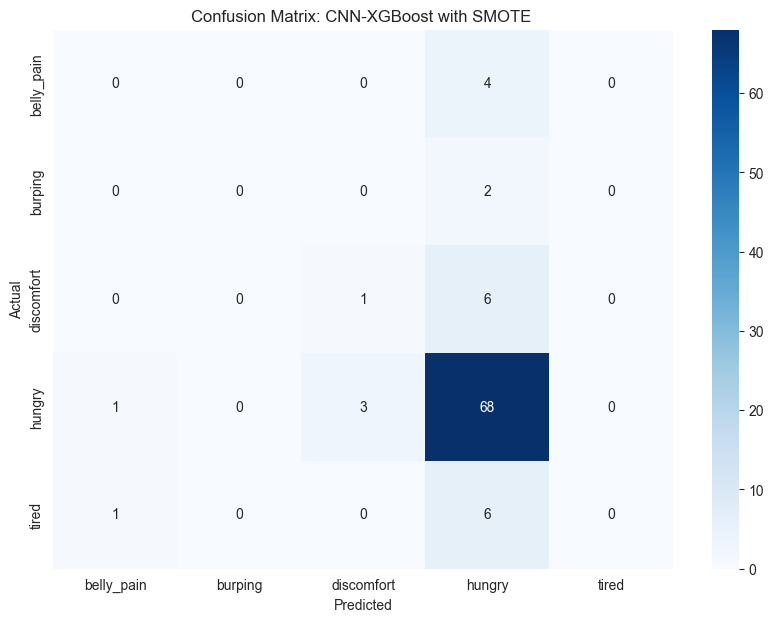

In [210]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_xgb)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN-XGBoost with SMOTE ')
plt.show()

21. CNN-LSTM with SMOTE

In [211]:
# CNN-LSTM Model with SMOTE
cnn_lstm_model_s = Sequential()
cnn_lstm_model_s.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_lstm_model_s.add(MaxPooling1D(pool_size=2))
cnn_lstm_model_s.add(LSTM(64, activation='relu'))
cnn_lstm_model_s.add(Dropout(0.5))
cnn_lstm_model_s.add(Dense(num_classes, activation='softmax'))
# Compile and Train the Model
cnn_lstm_model_s.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_lstm_model_s.fit(X_train_resampled_cnn, y_train_resampled_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/20
39/39 - 3s - loss: 5.0172 - accuracy: 0.2444 - val_loss: 1.6780 - val_accuracy: 0.0452 - 3s/epoch - 70ms/step
Epoch 2/20
39/39 - 0s - loss: 1.5482 - accuracy: 0.2468 - val_loss: 1.7202 - val_accuracy: 0.0065 - 192ms/epoch - 5ms/step
Epoch 3/20
39/39 - 0s - loss: 1.5379 - accuracy: 0.3919 - val_loss: 2.0453 - val_accuracy: 0.0097 - 207ms/epoch - 5ms/step
Epoch 4/20
39/39 - 0s - loss: 1.4810 - accuracy: 0.4218 - val_loss: 3.0681 - val_accuracy: 0.0194 - 205ms/epoch - 5ms/step
Epoch 5/20
39/39 - 0s - loss: 1.3285 - accuracy: 0.4532 - val_loss: 2.2270 - val_accuracy: 0.0194 - 204ms/epoch - 5ms/step
Epoch 6/20
39/39 - 0s - loss: 1.2942 - accuracy: 0.4556 - val_loss: 2.4465 - val_accuracy: 0.0258 - 189ms/epoch - 5ms/step
Epoch 7/20
39/39 - 0s - loss: 1.1260 - accuracy: 0.5137 - val_loss: 2.4439 - val_accuracy: 0.0323 - 201ms/epoch - 5ms/step
Epoch 8/20
39/39 - 0s - loss: 1.0239 - accuracy: 0.5444 - val_loss: 2.2641 - val_accuracy: 0.0387 - 211ms/epoch - 5ms/step
Epoch 9/20
39/39 -

In [212]:
# Make predictions on the test data
y_pred_cnn_lstm = cnn_lstm_model_s.predict(X_mfcc_test_cnn)

# Convert predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred_cnn_lstm, axis=1)
y_true_classes = np.argmax(y_test_cnn, axis=1)

3/3 [==============================] - 0s 0s/step


In [213]:
# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

new_row_cv = pd.DataFrame([["CNN-LSTM with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


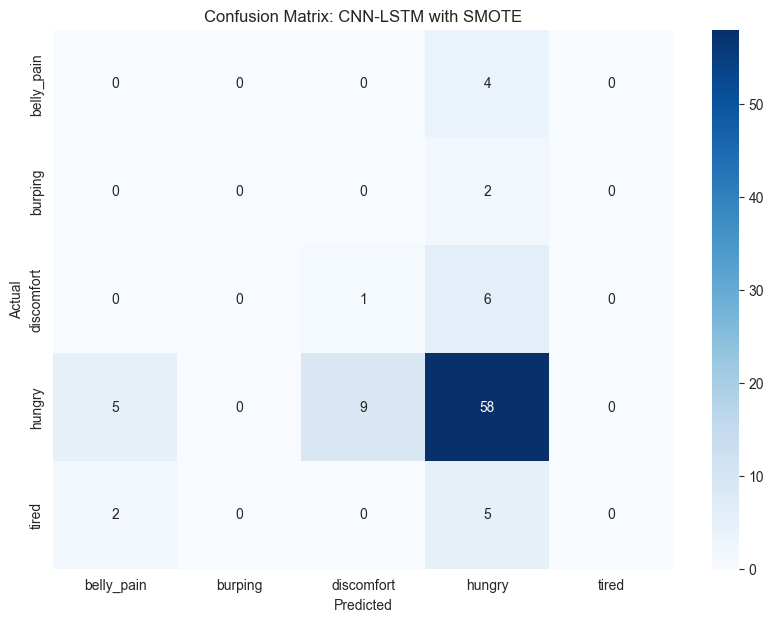

In [214]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN-LSTM with SMOTE')
plt.show()

22. Ensemble Model with SMOTE

In [215]:
# Extracting features using already trained CNN model with SMOTE  
train_features = cnn_model_s.predict(X_train_resampled_cnn)  
test_features = cnn_model_s.predict(X_mfcc_test_cnn)

3/3 [==============================] - 0s 4ms/step


In [216]:
# Define base classifiers and meta-classifier for stacking
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='linear', probability=True)),
    ('xgb',
     XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
]

In [217]:
# Meta-classifier (KNN)
meta_learner = KNeighborsClassifier(n_neighbors=5)  # RandomForestClassifier(n_estimators=100, random_state=42) 

In [218]:
#  Create a stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

In [219]:
train_features.shape

(1550, 5)

In [220]:
y_train_resampled_cnn.shape

(1550, 5)

In [221]:
# the number of samples per class after applying SMOTE
y_train_1d=np.argmax(y_train_resampled_cnn, axis=1)
y_train_1d.shape

(1550,)

In [222]:
# Train the stacking classifier
stacking_clf.fit(train_features, y_train_1d)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svm', SVC(kernel='linear', probability=True)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              fe...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=KNeighborsClassifier())

In [223]:
#   Make predictions with the stacking model
y_pred_stacking = stacking_clf.predict(test_features)

In [224]:
y_mfcc_test.shape

(92,)

In [225]:
test_features.shape

(92, 5)

In [226]:
# Step 7: Evaluate the model
accuracy = accuracy_score(y_mfcc_test, y_pred_stacking)
f1 = f1_score(y_mfcc_test, y_pred_stacking, average='weighted')
precision = precision_score(y_mfcc_test, y_pred_stacking, average='weighted')
recall = recall_score(y_mfcc_test, y_pred_stacking, average='weighted')

print(f'Ensemble Accuracy: {accuracy * 100:.2f}%')
print(f'Ensemble F1 Score: {f1:.2f}')
print(f'Ensemble Precision: {precision:.2f}')
print(f'Ensemble Recall: {recall:.2f}')
new_row_cv = pd.DataFrame([["Ensemble Model(CNN,RandomForest, XGBoost, SVM,KNN) with SMOTE", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
results_df


Ensemble Accuracy: 71.74%
Ensemble F1 Score: 0.67
Ensemble Precision: 0.63
Ensemble Recall: 0.72


,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.797101,0.747401,0.704978,0.797101
6,RNN,0.804348,0.748988,0.700758,0.804348
7,CNN,0.739130,0.669401,0.611694,0.739130
8,CNN-XGBoost,0.739130,0.669401,0.611694,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609


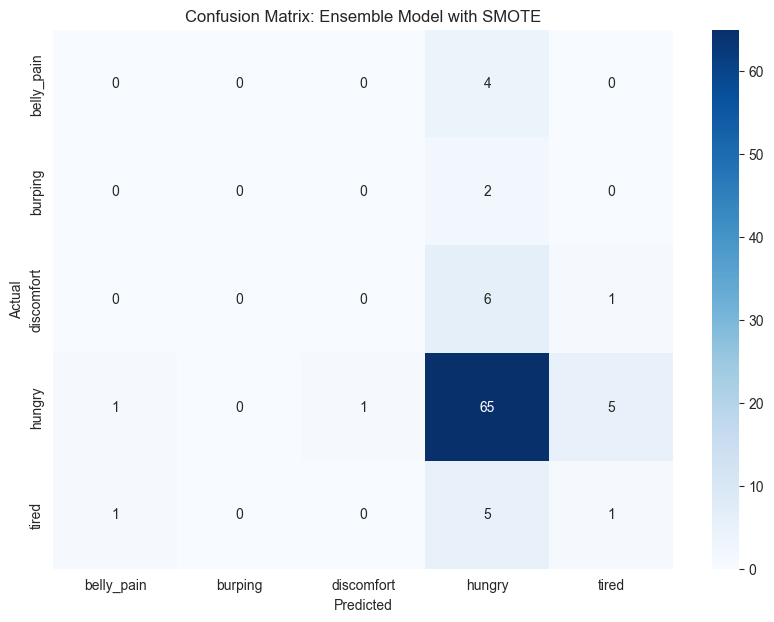

In [227]:
cm = confusion_matrix(y_mfcc_test, y_pred_stacking)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Ensemble Model with SMOTE')
plt.show()

In [228]:
n_results_df=results_df.iloc[11:]
n_results_df 

,Model,Accuracy,F1 Score,Precision,Recall
11,SVM with SMOTE,0.976774,0.976218,0.977727,0.976774
12,KNN with SMOTE,0.843871,0.802571,0.869970,0.843871
13,Random Forest with SMOTE,0.996129,0.996123,0.996210,0.996129
14,AdaBoost with SMOTE,0.293548,0.207859,0.258981,0.293548
15,XGBoost with SMOTE,0.989032,0.988965,0.989228,0.989032
16,LSTM with SMOTE,0.739130,0.726404,0.714608,0.739130
17,RNN with SMOTE,0.666667,0.682885,0.701946,0.666667
18,CNN with SMOTE,0.750000,0.675000,0.613636,0.750000
19,CNN-XGBoost with SMOTE,0.980000,0.979762,0.980478,0.980000
20,CNN-LSTM with SMOTE,0.641304,0.626520,0.612826,0.641304


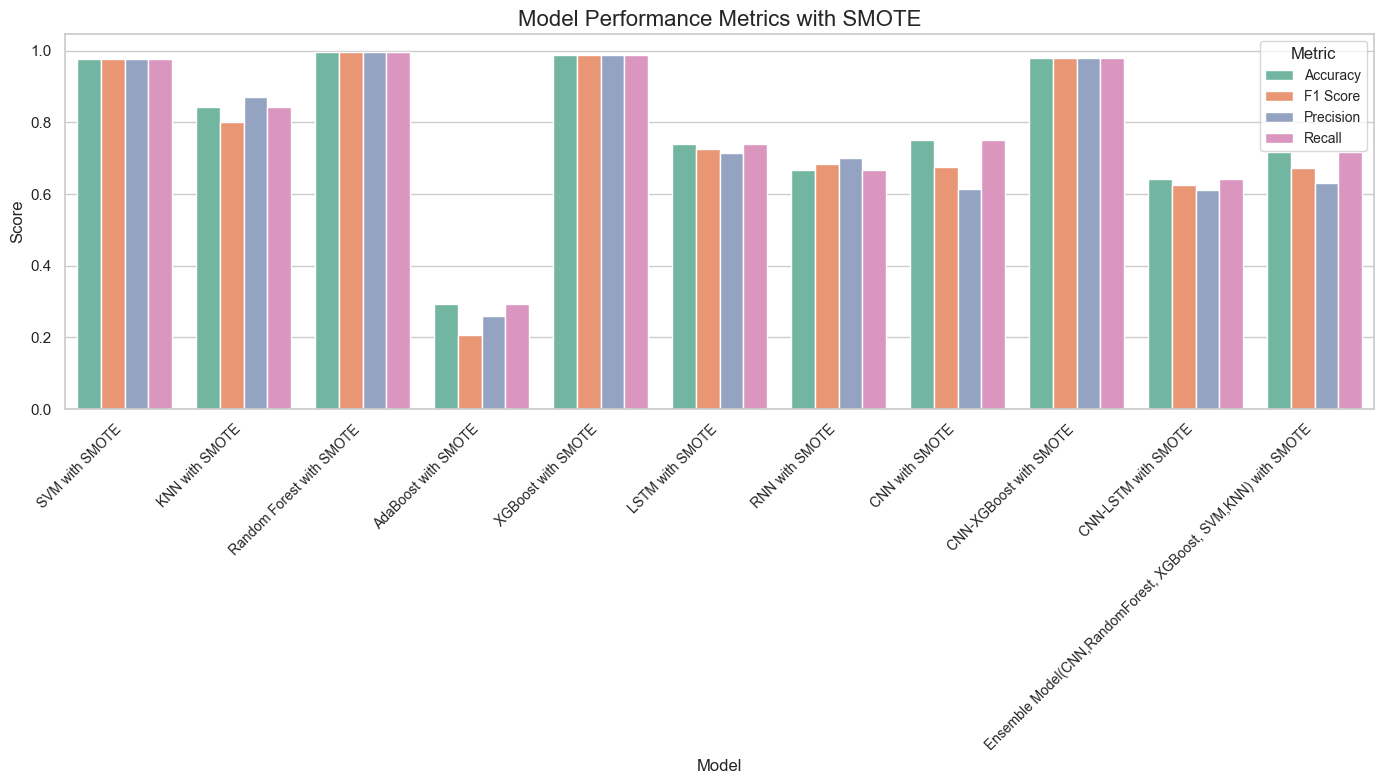

In [229]:
'''# Reshape the dataframe for easier plotting
n_results_df_melted = n_results_df.melt(
    id_vars="Model", var_name="Metric", value_name="Score"
)

# Set the plot style
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Create the barplot
sns.barplot(
    data=n_results_df_melted, 
    x="Model", 
    y="Score", 
    hue="Metric", 
    palette="Set2"
)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.title("Model Performance Metrics with SMOTE", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Metric", fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()'''

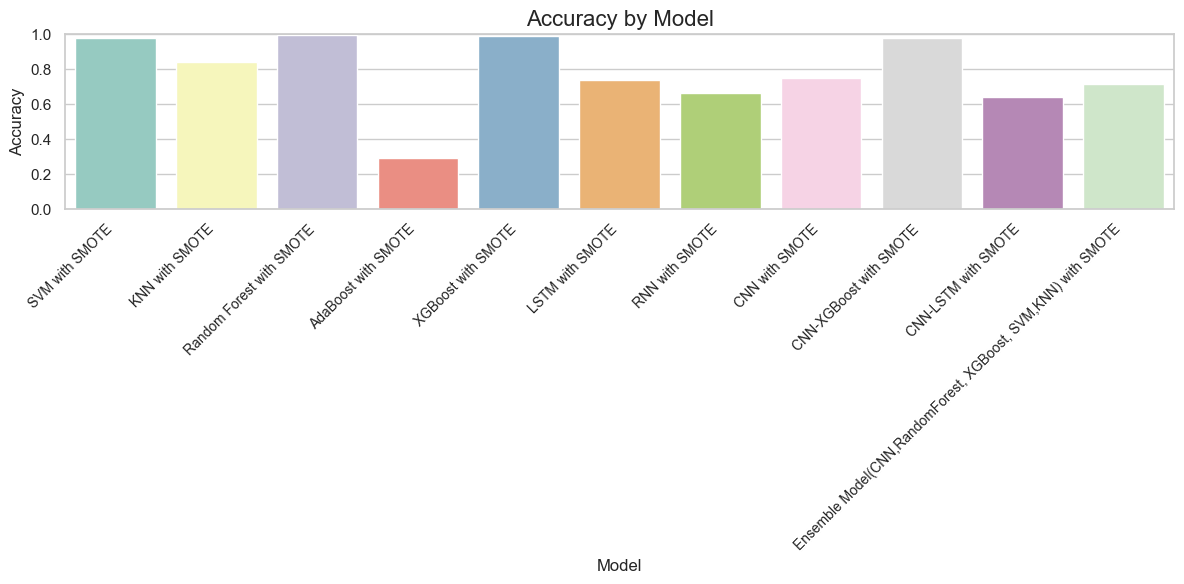

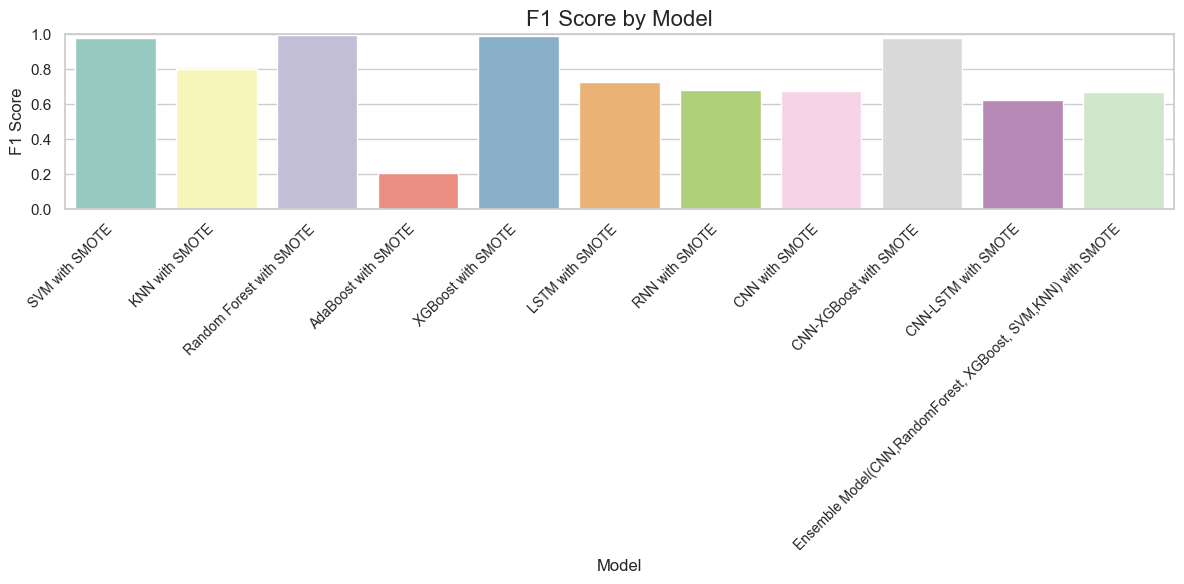

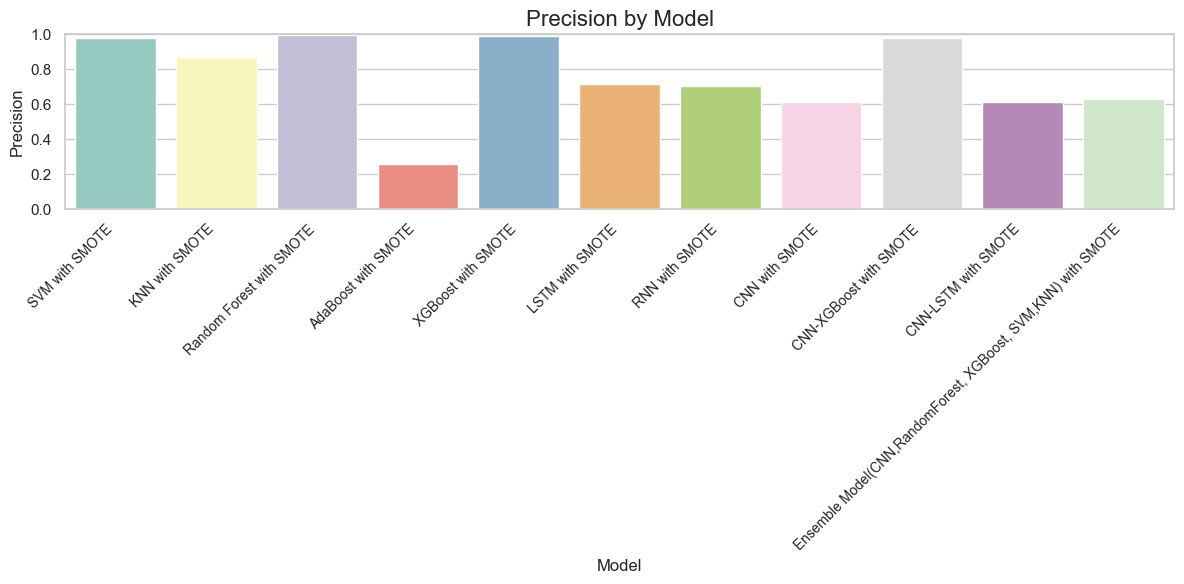

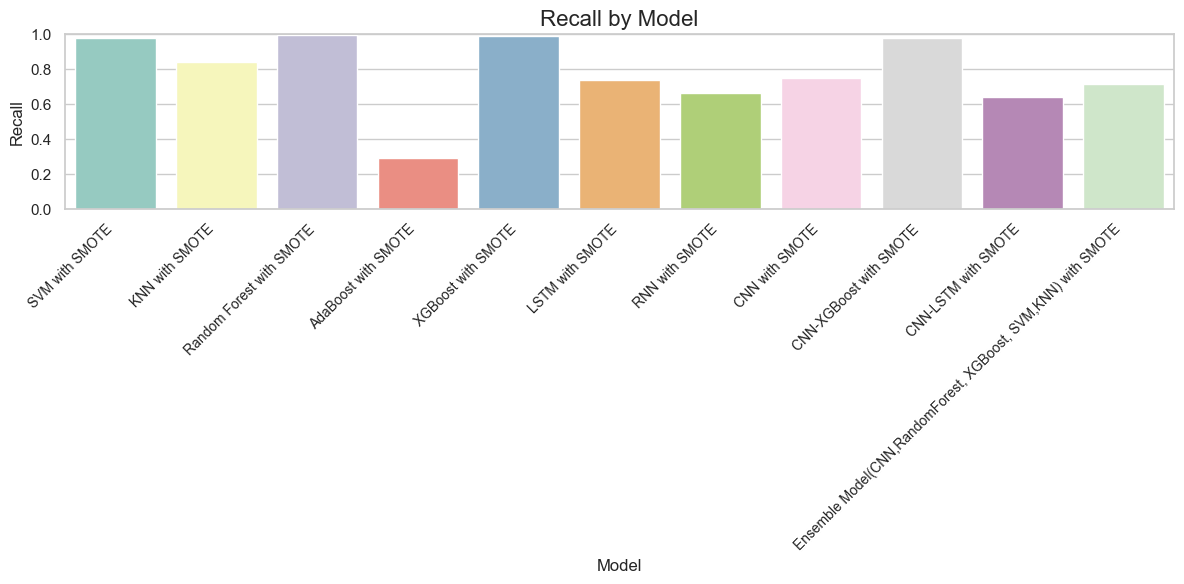

In [230]:
'''# List of metrics to plot (excluding 'Model')
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

# Set the plot style
sns.set_theme(style="whitegrid")

# Loop through each metric and create a separate bar chart
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=n_results_df, 
        x="Model", 
        y=metric, 
        palette="Set3"
    )
    # Customizing the plot
    plt.title(f"{metric} by Model", fontsize=16)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.ylim(0, 1)  # Metrics range between 0 and 1
    plt.tight_layout()
    plt.show()'''